<a href="https://colab.research.google.com/github/musicjae/recommender-system/blob/main/dangam_NCF_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ignore  the warnings
import warnings

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)
import keras
from keras.optimizers import Adam
from keras.layers.merge import dot
from keras.layers import Dropout, Flatten, Activation, Input, Embedding
import numpy as np



DATA=pd.read_csv('/content/drive/MyDrive/datasets/recommender_system/ml-1M/ratings.csv')

df = DATA.copy()

##############################################################################
##########################  preprocessing   ##################################
##############################################################################

df['userId'].unique() # 중복된 것을 모두 제거하고 유일한 값만을 남긴다.
df['itemId'].unique()

# Encoding

df.userId = df.userId.astype('category').cat.codes.values
df.itemId = df.itemId.astype('category').cat.codes.values

"""
Note that for 671 users and 9066 movies we can have a maximum of 671*9066 = 6083286 ratings. 
But note that we have only 100004 ratings with us. Hence the utility matrix has only about 1.6 % of the total values.
"""

# creating utility matrix.
index = list(df['userId'].unique())
columns = list(df['itemId'].unique())
index = sorted(index)
columns = sorted(columns)

util_df = pd.pivot_table(data=df, values='rating', index='userId', columns='itemId')  # 6060,3706
util_df.fillna(0)

## Creating Trainset, Val set

users = df.userId.unique()
items = df.itemId.unique()

u2i = {u:i for i,u in enumerate(users)}
m2i = {m:i for i,m in enumerate(items)}

i2u = {i:u for i,u in enumerate(users)}
i2m = {i:m for i,m in enumerate(items)}

df['userId'] = df['userId'].apply(lambda x: u2i[x])
df['itemId'] = df['itemId'].apply(lambda x: m2i[x])

split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]

In [37]:
# Ignore  the warnings
import warnings

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)
import keras
from keras.optimizers import Adam
from keras.layers.merge import dot
from keras.layers import Dropout, Flatten, Activation, Input, Embedding
import numpy as np
from keras import layers
from keras.callbacks import EarlyStopping


n_movies = len(df['itemId'].unique())
n_users = len(df['userId'].unique())
n_latent_factors = 64  # hyperparamter to deal with.
BATCH_SIZE = 128
EPOCHS = 10

############################################################################
############################ Modeling ######################################
############################################################################

dropout = keras.layers.Dropout(0.1)

############################## GMF ######################################


user_input= Input(shape=(1,), name='user_input', dtype='int64')  # None, 1
user_embedding_gmf = Embedding(n_users, n_latent_factors, name='user_embedding_gmf')(user_input)  # None, 1, 64
user_vec_gmf = Flatten(name='FlattenUsers_gmf')(user_embedding_gmf)  # None, None

movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
movie_embedding_gmf = Embedding(n_movies, n_latent_factors, name='movie_embedding_gmf')(movie_input)
movie_vec_gmf = Flatten(name='FlattenMovies_gmf')(movie_embedding_gmf)

gmf = dot([user_vec_gmf, movie_vec_gmf], name='dot', axes=1)


############################ MLP #########################################


#user_input = Input(shape=(1,), name='user_input', dtype='int64')  # None, 1
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding_mlp', embeddings_initializer='he_normal',
                           embeddings_regularizer=keras.regularizers.l2(1e-4))(user_input)  # None, 1, 64
user_vec = Flatten(name='FlattenUsers')(user_embedding)  # None, None
user_bias = Embedding(n_users,1)

#movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding_mlp', embeddings_initializer='he_normal',
                            embeddings_regularizer=keras.regularizers.l2(1e-4))(movie_input)
movie_vec = Flatten(name='FlattenMovies_mlp')(movie_embedding)
movie_bias = Embedding(n_movies,1)

concat = keras.layers.Concatenate()([user_vec, movie_vec])
#result = concat + user_bias + movie_bias


x = layers.Dense(16, activation='elu')(concat)
x = dropout(x)
x = layers.Dense(32, activation='elu')(x)
x = dropout(x)
x = layers.Dense(16, activation='elu')(x)
x = dropout(x)
x  = layers.Dense(8,activation='elu')(x)
x = dropout(x)
mlp = layers.Dense(1,activation='elu')(x)

result = keras.layers.Add()([gmf,mlp])

NeuMF = keras.models.Model([user_input, movie_input], result)

##############################################################################
##############################################################################
##############################################################################


#gmf.compile(optimizer=Adam(lr=1e-3), loss='mse')
#history = gmf.fit([train.userId, train.itemId], train.rating, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([valid.userId, valid.itemId], valid.rating), verbose=1)


es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=5)

NeuMF.compile(optimizer=Adam(lr=1e-3,beta_1=0.95), loss= keras.losses.MeanAbsoluteError(), metrics = [keras.metrics.RootMeanSquaredError()])
history = NeuMF.fit([train.userId, train.itemId], train.rating, batch_size=BATCH_SIZE, epochs=100, validation_data=([valid.userId, valid.itemId], valid.rating), callbacks=[es])
NeuMF.save('/content/drive/MyDrive/datasets/recommender_system/ml-1M/models/NeuMF2')

### adam_ beta1 = 0.95인 경우가 좀 더 rsme가 낮은 경향이 있다.



Epoch 1/100
7815/7815 [==============================] - 97s 12ms/step - loss: 0.8318 - root_mean_squared_error: 1.0275 - val_loss: 0.6919 - val_root_mean_squared_error: 0.8650
Epoch 2/100
7815/7815 [==============================] - 98s 13ms/step - loss: 0.6894 - root_mean_squared_error: 0.8626 - val_loss: 0.5984 - val_root_mean_squared_error: 0.7703
Epoch 3/100
7815/7815 [==============================] - 96s 12ms/step - loss: 0.6117 - root_mean_squared_error: 0.7853 - val_loss: 0.5377 - val_root_mean_squared_error: 0.7137
Epoch 4/100
7815/7815 [==============================] - 95s 12ms/step - loss: 0.5655 - root_mean_squared_error: 0.7394 - val_loss: 0.5027 - val_root_mean_squared_error: 0.6774
Epoch 5/100
7815/7815 [==============================] - 96s 12ms/step - loss: 0.5349 - root_mean_squared_error: 0.7098 - val_loss: 0.4778 - val_root_mean_squared_error: 0.6542
Epoch 6/100
7815/7815 [==============================] - 96s 12ms/step - loss: 0.5128 - root_mean_squared_error: 0.

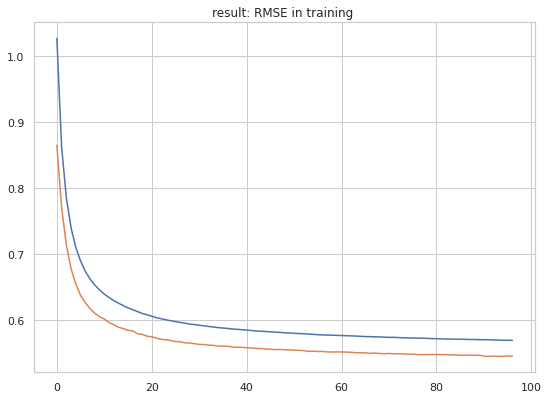

In [40]:
fig = plt.figure(figsize=(8,6))

sub1 = fig.add_subplot(111)
sub1.set_title('result: RMSE in training ')
sub1.plot(history.history['root_mean_squared_error'])
sub1.plot(history.history['val_root_mean_squared_error'])

plt.show()


In [39]:
print(NeuMF.evaluate()

<bound method Model.evaluate of <tensorflow.python.keras.engine.functional.Functional object at 0x7fea537204a8>>


user_input, item_input, result 모두 텐서 형태라는 점에 주의

In [20]:
import tensorflow as tf

In [41]:


# 참고: https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699

movie_titles = pd.read_csv('/content/drive/MyDrive/datasets/recommender_system/ml-1M/movies.csv')
movie_titles = movie_titles[['itemId','title']]

model = keras.models.load_model('/content/drive/MyDrive/datasets/recommender_system/ml-1M/models/NeuMF')
train=pd.read_csv('/content/drive/MyDrive/datasets/recommender_system/ml-1M/ratings.csv')

df = train.copy()

users = tf.convert_to_tensor(pd.Series(list(set(df.userId)))) # 6040
movies = tf.convert_to_tensor(pd.Series(list(set(df.itemId)))) # 3706


get_list=[]
for i in range(len(movies)):
    predictions = model.predict([users[1], movies[i]])  # 유저 2에 대한 영화 추천 목록
    get_list.append(predictions)


#predictions = np.array([a[0] for a in predictions]) # nested list 풀기
get_list = [b[0] for b in get_list] # list unpack
get_list2 = [b[0] for b in get_list] # same

recommended_list = np.flip(np.argsort(np.array(get_list2)))
top_five_recommended_list = recommended_list[:5]


for i in range(len(movie_titles)):
    for j in range(5):
        if top_five_recommended_list[j] == movie_titles['itemId'][i]:
            print(movie_titles['title'][i])



IndexError: ignored